# Project Codes for  Wrangle and Analyze Data

In [220]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import glob

## gather data

I have not applied Twitter API successfully, so I just used Udacity raw data as downloaded.

In [221]:
df_twitter_archived = pd.read_csv("twitter-archive-enhanced.csv")

In [222]:
df_image_predictions = pd.read_csv("image-predictions.tsv")

In [223]:
import json

data = []
with open('tweet-json.txt') as f:
    for line in f:
        data.append(json.loads(line))
df_tweeter_json = pd.DataFrame.from_dict(data)

## Assess

In [224]:
df_twitter_archived.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [225]:
df_twitter_archived.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [226]:
df_twitter_archived.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [227]:
df_image_predictions.head(1)

,tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog
0,666020888022790149\thttps://pbs.twimg.com/medi...


In [228]:
df_image_predictions.describe()

,tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog
count,2075
unique,2075
top,707038192327901184\thttps://pbs.twimg.com/medi...
freq,1


In [229]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 1 columns):
 #   Column                                                                          Non-Null Count  Dtype 
---  ------                                                                          --------------  ----- 
 0   tweet_id	jpg_url	img_num	p1	p1_conf	p1_dog	p2	p2_conf	p2_dog	p3	p3_conf	p3_dog  2075 non-null   object
dtypes: object(1)
memory usage: 16.3+ KB


In [230]:
df_tweeter_json.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN


In [231]:
df_tweeter_json.describe()

,id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,quoted_status_id
count,2.354000e+03,7.800000e+01,7.800000e+01,2354.000000,2354.000000,2.900000e+01
mean,7.426978e+17,7.455079e+17,2.014171e+16,3164.797366,8080.968564,8.162686e+17
std,6.852812e+16,7.582492e+16,1.252797e+17,5284.770364,11814.771334,6.164161e+16
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17
25%,6.783975e+17,6.757419e+17,3.086374e+08,624.500000,1415.000000,7.888183e+17
50%,7.194596e+17,7.038708e+17,4.196984e+09,1473.500000,3603.500000,8.340867e+17
75%,7.993058e+17,8.257804e+17,4.196984e+09,3652.000000,10122.250000,8.664587e+17
max,8.924206e+17,8.862664e+17,8.405479e+17,79515.000000,132810.000000,8.860534e+17


In [232]:
df_tweeter_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2354 non-null   object 
 1   id                             2354 non-null   int64  
 2   id_str                         2354 non-null   object 
 3   full_text                      2354 non-null   object 
 4   truncated                      2354 non-null   bool   
 5   display_text_range             2354 non-null   object 
 6   entities                       2354 non-null   object 
 7   extended_entities              2073 non-null   object 
 8   source                         2354 non-null   object 
 9   in_reply_to_status_id          78 non-null     float64
 10  in_reply_to_status_id_str      78 non-null     object 
 11  in_reply_to_user_id            78 non-null     float64
 12  in_reply_to_user_id_str        78 non-null     o

#### define 
the format in tsv file is not good looking, we need to make it displayed column by column in csv file

#### code

In [233]:
df_image_predictions = pd.read_csv("image-predictions.tsv",sep='\t')

#### test

In [234]:
df_image_predictions.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


#### define
column "jpg_url" has duplicate values， we need to find out

In [235]:
df_image_predictions[df_image_predictions['jpg_url'].duplicated()==True]['jpg_url'].value_counts()

https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg    1
https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg    1
https://pbs.twimg.com/media/CpmyNumW8AAAJGj.jpg    1
https://pbs.twimg.com/media/CtVAvX-WIAAcGTf.jpg    1
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg    1
                                                  ..
https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg    1
https://pbs.twimg.com/media/Ck2d7tJWUAEPTL3.jpg    1
https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg    1
https://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg    1
https://pbs.twimg.com/media/CcG07BYW0AErrC9.jpg    1
Name: jpg_url, Length: 66, dtype: int64

#### define
column "rating_denominator" has some values that is not 10， we need to find out

In [236]:
df_twitter_archived.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### define 
dog name was not extracted correctly

In [237]:
dog_name = df_twitter_archived.name.str.contains('^[a-z]', regex = True)

In [238]:
dog_name.value_counts().sort_index()

False    2247
True      109
Name: name, dtype: int64

we can see more than 100 dogs' name are not correctly extracted, they are start with lower word，however, incorrect names will not impact data analysis, so I will correct those names one by one.

In [240]:
df_twitter_archived[dog_name].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

#### tidiness issues 

 1. for "source" column, should be split, what I want is only the last few words from the long URL
 2. Dog stages need to be combined into one column
 3. we have raw data from 3 tables, they share the common tweet ID, in oder to view data clearly, we need to combined 3 files to 1 file

#### data quality issues ：
1.	timestamp is, created_at an object, not datetime, we need to change them to datetime
2. "geo","coordinates" is a null column, we need to drop them
3.	p1_dog, p2_dog, p3_dog is an object, should be a bool, we need to change them to bool
4. "place" only has 1 row data, we need to drop them
5. a few data of "rating_numerator","rating_denominator" are not correctly extracted, for example, "This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv", the rating_numerator" should be 9, also, there are many "rating_denominator" is not 100, we need to check those numbers, to clean the data, we need to extract the data again, for some cases with complicated format, we may even need to manually correct one by one.
6. tweet_id is an int, we should change them as str
7. jpg_url has duplicate URLs, we need to drop duplicated ones
8. more than 100 dogs' name are not correctly extracted, they are start with lower word, to clean the data, we need to extract the data again, for some cases with complicated format, we may even need to manually correct one by one.


## clean

#### define 
the column name of "id" refers to tweeter ID, we need to change them to "tweet_id"

#### code

In [242]:
df_tweeter_json.rename(columns={"id":"tweet_id"},inplace=True)

#### test

In [243]:
df_tweeter_json.head(2)

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN


#### define: combine 3 files to 1 csv file

#### code

In [244]:
df_twitter_archived_tweeter_json = pd.merge(df_twitter_archived,df_tweeter_json,on="tweet_id",how="outer")

In [245]:
df_combined = pd.merge(df_twitter_archived_tweeter_json,df_image_predictions,on="tweet_id",how="outer")
df_clean =df_combined.copy()

#### test

In [246]:
df_clean.head(2)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [247]:
df_clean.to_csv("combine all file.csv")

In [248]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tweet_id                       2356 non-null   int64  
 1   in_reply_to_status_id_x        78 non-null     float64
 2   in_reply_to_user_id_x          78 non-null     float64
 3   timestamp                      2356 non-null   object 
 4   source_x                       2356 non-null   object 
 5   text                           2356 non-null   object 
 6   retweeted_status_id            181 non-null    float64
 7   retweeted_status_user_id       181 non-null    float64
 8   retweeted_status_timestamp     181 non-null    object 
 9   expanded_urls                  2297 non-null   object 
 10  rating_numerator               2356 non-null   int64  
 11  rating_denominator             2356 non-null   int64  
 12  name                           2356 non-null   o

In [249]:
df_clean.describe()

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,in_reply_to_status_id_y,in_reply_to_user_id_y,retweet_count,favorite_count,quoted_status_id,img_num,p1_conf,p2_conf,p3_conf
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,7.800000e+01,7.800000e+01,2354.000000,2354.000000,2.900000e+01,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,7.455079e+17,2.014171e+16,3164.797366,8080.968564,8.162686e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,7.582492e+16,1.252797e+17,5284.770364,11814.771334,6.164161e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,6.757419e+17,3.086374e+08,624.500000,1415.000000,7.888183e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,7.038708e+17,4.196984e+09,1473.500000,3603.500000,8.340867e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,8.257804e+17,4.196984e+09,3652.000000,10122.250000,8.664587e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,8.862664e+17,8.405479e+17,79515.000000,132810.000000,8.860534e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### define: covert tweet_id to a string

#### code

In [250]:
df_clean["tweet_id"] = df_clean["tweet_id"].astype("str")

#### test

In [251]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tweet_id                       2356 non-null   object 
 1   in_reply_to_status_id_x        78 non-null     float64
 2   in_reply_to_user_id_x          78 non-null     float64
 3   timestamp                      2356 non-null   object 
 4   source_x                       2356 non-null   object 
 5   text                           2356 non-null   object 
 6   retweeted_status_id            181 non-null    float64
 7   retweeted_status_user_id       181 non-null    float64
 8   retweeted_status_timestamp     181 non-null    object 
 9   expanded_urls                  2297 non-null   object 
 10  rating_numerator               2356 non-null   int64  
 11  rating_denominator             2356 non-null   int64  
 12  name                           2356 non-null   o

#### define: some rating_numerators and rating_denominators are not correctly extracted, manually correct one by one

#### code

In [252]:
df_clean.loc[313, 'rating_numerator'] = '13'  #835246439529840000
df_clean.loc[784, 'rating_numerator'] = '14'  #775096608509886000
df_clean.loc[1068, 'rating_numerator'] = '14'  # 740373189193256000
df_clean.loc[1165, 'rating_numerator'] = '13'  #722974582966214000
df_clean.loc[1202, 'rating_numerator'] = '11'  #716439118184652000
df_clean.loc[1662, 'rating_numerator'] = '10'  #682962037429899000
df_clean.loc[2335, 'rating_numerator'] = '9'  #666287406224695000
df_clean.loc[313, 'rating_denominator'] = '10'
df_clean.loc[784, 'rating_denominator'] = '10'
df_clean.loc[1068, 'rating_denominator'] = '10'
df_clean.loc[1165, 'rating_denominator'] = '10'
df_clean.loc[1202, 'rating_denominator'] = '10'
df_clean.loc[1662, 'rating_denominator'] = '10'
df_clean.loc[2335, 'rating_denominator'] = '10'

#### test (I exported it to a csv file and check one by one)

In [253]:
df_clean.to_csv("dog-rating-clean.csv")

#### define: some decimal rating_numerators are not correctly extracted, manually correct one by one

#### code

In [254]:
import re

df_check_decimal = df_clean["text"]

digitals = re.compile(r'-?\d+\.?\d*e?-?\d*?', re.I)
for i in df_check_decimal:
    digital = re.findall(digitals, i)
    [str(i) for i in digital]

    # can use "print" to test if those digitals are extracted, I will not print here because it will show a long list in HTML file

####  I have found some texts with decimals as below, luckily the volume is not big

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948

RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu?€?

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq

I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD

In [255]:
df_clean.loc[45, 'rating_numerator'] = '13.5'  
df_clean.loc[340, 'rating_numerator'] = '9.75' 
df_clean.loc[695, 'rating_numerator'] = '9.75' 
df_clean.loc[763, 'rating_numerator'] = '11.27'
df_clean.loc[1689, 'rating_numerator'] = '9.5'  
df_clean.loc[1712, 'rating_numerator'] = '11.26' 

#### test

I exported it to a csv file and check one by one

In [256]:
df_clean.to_csv("dog-rating-clean2.csv")

#### define
drop some null columns or missing data columns

#### code

In [257]:
df_clean.drop(columns=["id_str","full_text","source_y","in_reply_to_status_id_y",
                     "in_reply_to_status_id_str","in_reply_to_user_id_y","geo","coordinates","contributors","retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"],axis=1,inplace=True)

#### test

In [258]:
df_clean.head(2)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


#### define:
we can see "source" column, e.g. <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>, it's too long, what I want is only "Twitter for iPhone", let's clean this column

#### code

In [259]:
df_clean['new_source'] = df_clean.source_x.str.extract('>(.*)')
df_clean['new_source'] = df_clean['new_source'].str[0:-4]
df_clean.drop(columns=["source_x"],axis=1,inplace=True)


#### test

In [260]:
df_clean.head(2)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_source
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,Twitter for iPhone
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Twitter for iPhone


#### define:
Also noted, the date format is of "created_at" is not very friendly, I want to know the day of the week

#### code

In [261]:
df_clean['day of the week'] = df_clean.created_at.str[0:3]

#### test

In [262]:
df_clean.head(2)

,tweet_id,in_reply_to_status_id_x,in_reply_to_user_id_x,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,new_source,day of the week
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,Twitter for iPhone,Tue
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Twitter for iPhone,Tue


In [263]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   tweet_id                       2356 non-null   object 
 1   in_reply_to_status_id_x        78 non-null     float64
 2   in_reply_to_user_id_x          78 non-null     float64
 3   timestamp                      2356 non-null   object 
 4   text                           2356 non-null   object 
 5   expanded_urls                  2297 non-null   object 
 6   rating_numerator               2356 non-null   object 
 7   rating_denominator             2356 non-null   object 
 8   name                           2356 non-null   object 
 9   doggo                          2356 non-null   object 
 10  floofer                        2356 non-null   object 
 11  pupper                         2356 non-null   object 
 12  puppo                          2356 non-null   o

#### define
we can see columns with "true" or false are object, they should be Boolean. and some time columns are objects, we need to adjust them to datetime

#### code

In [264]:
df_clean.p1_dog = df_clean.p1_dog.astype("bool")
df_clean.p2_dog = df_clean.p2_dog.astype("bool")
df_clean.p3_dog = df_clean.p3_dog.astype("bool")
df_clean.truncated = df_clean.truncated.astype("bool")
df_clean.favorited = df_clean.favorited.astype("bool")
df_clean.retweeted = df_clean.retweeted.astype("bool")
df_clean.possibly_sensitive = df_clean.possibly_sensitive.astype("bool")
df_clean.possibly_sensitive_appealable = df_clean.possibly_sensitive_appealable.astype("bool")

In [265]:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)
df_clean.created_at = pd.to_datetime(df_clean.created_at)

#### test

In [266]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2356 non-null   object             
 1   in_reply_to_status_id_x        78 non-null     float64            
 2   in_reply_to_user_id_x          78 non-null     float64            
 3   timestamp                      2356 non-null   datetime64[ns, UTC]
 4   text                           2356 non-null   object             
 5   expanded_urls                  2297 non-null   object             
 6   rating_numerator               2356 non-null   object             
 7   rating_denominator             2356 non-null   object             
 8   name                           2356 non-null   object             
 9   doggo                          2356 non-null   object             
 10  floofer                 

In [267]:
df_clean.describe()

,in_reply_to_status_id_x,in_reply_to_user_id_x,retweet_count,favorite_count,quoted_status_id,img_num,p1_conf,p2_conf,p3_conf
count,7.800000e+01,7.800000e+01,2354.000000,2354.000000,2.900000e+01,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.455079e+17,2.014171e+16,3164.797366,8080.968564,8.162686e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,7.582492e+16,1.252797e+17,5284.770364,11814.771334,6.164161e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.757419e+17,3.086374e+08,624.500000,1415.000000,7.888183e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.038708e+17,4.196984e+09,1473.500000,3603.500000,8.340867e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,8.257804e+17,4.196984e+09,3652.000000,10122.250000,8.664587e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.862664e+17,8.405479e+17,79515.000000,132810.000000,8.860534e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### define
a few important columns have missing data, let's remove those missing data columns

#### code

In [268]:
df_clean = df_clean[~df_clean["p1"].isnull()]
df_clean = df_clean[~df_clean["retweet_count"].isnull()]

#### test

In [269]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2073 non-null   object             
 1   in_reply_to_status_id_x        23 non-null     float64            
 2   in_reply_to_user_id_x          23 non-null     float64            
 3   timestamp                      2073 non-null   datetime64[ns, UTC]
 4   text                           2073 non-null   object             
 5   expanded_urls                  2073 non-null   object             
 6   rating_numerator               2073 non-null   object             
 7   rating_denominator             2073 non-null   object             
 8   name                           2073 non-null   object             
 9   doggo                          2073 non-null   object             
 10  floofer                 

#### define:
There are still some columns with missing /useless data, let's drop them.

#### code

In [270]:
df_clean.drop(columns=["place","quoted_status_id","quoted_status_id_str","quoted_status","in_reply_to_user_id_str","in_reply_to_status_id_x", "in_reply_to_screen_name","entities","extended_entities","user","in_reply_to_user_id_x"],axis=1,inplace=True)

#### test

In [271]:
df_clean.info()           

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2073 non-null   object             
 1   timestamp                      2073 non-null   datetime64[ns, UTC]
 2   text                           2073 non-null   object             
 3   expanded_urls                  2073 non-null   object             
 4   rating_numerator               2073 non-null   object             
 5   rating_denominator             2073 non-null   object             
 6   name                           2073 non-null   object             
 7   doggo                          2073 non-null   object             
 8   floofer                        2073 non-null   object             
 9   pupper                         2073 non-null   object             
 10  puppo                   

#### define: there are 4 columns for dog's stage, actually we can merge them into 1 column

#### code

In [272]:
df_clean.doggo.replace('None', '', inplace=True)
df_clean.floofer.replace('None', '', inplace=True)
df_clean.pupper.replace('None', '', inplace=True)
df_clean.puppo.replace('None', '', inplace=True)
df_clean['stage'] = df_clean.doggo + df_clean.floofer + df_clean.pupper + df_clean.puppo
df_clean.loc[df_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'
df_clean.loc[df_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'
df_clean.loc[df_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

#### test

In [273]:
df_clean.stage.value_counts()

                 1753
pupper            210
doggo              67
puppo              23
doggo,pupper       11
floofer             7
doggo,floofer       1
doggo,puppo         1
Name: stage, dtype: int64

#### define:

let's drop "doggo", "floofer", "pupper","puppo" because we already have a combined column as stage
we see there are many columns are regarding "retweet", however, they are not in near columns, let's adjust the column oders.

#### code

In [274]:
df_clean_retweeted = df_clean.retweeted
df_clean_retweeted_status = df_clean.retweeted_status
df_clean = df_clean.drop('retweeted',axis=1)
df_clean = df_clean.drop('retweeted_status',axis=1)
df_clean.insert(4,'retweeted',df_clean_retweeted)
df_clean.insert(5,'retweeted_status',df_clean_retweeted)
df_clean = df_clean.drop('doggo',axis=1)
df_clean = df_clean.drop('floofer',axis=1)
df_clean = df_clean.drop('pupper',axis=1)
df_clean = df_clean.drop('puppo',axis=1)

#### test

In [275]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2355
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2073 non-null   object             
 1   timestamp                      2073 non-null   datetime64[ns, UTC]
 2   text                           2073 non-null   object             
 3   expanded_urls                  2073 non-null   object             
 4   retweeted                      2073 non-null   bool               
 5   retweeted_status               2073 non-null   bool               
 6   rating_numerator               2073 non-null   object             
 7   rating_denominator             2073 non-null   object             
 8   name                           2073 non-null   object             
 9   created_at                     2073 non-null   datetime64[ns, UTC]
 10  truncated               

In [276]:
df_clean.describe()

,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2073.000000,2073.000000,2073.000000,2073.000000,2.073000e+03,2.073000e+03
mean,2976.089243,8556.718283,1.203570,0.594532,1.346665e-01,6.034005e-02
std,5054.897526,12098.640994,0.561856,0.271234,1.006830e-01,5.092769e-02
min,16.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,634.000000,1674.000000,1.000000,0.364095,5.390140e-02,1.619920e-02
50%,1408.000000,3864.000000,1.000000,0.588230,1.186220e-01,4.947150e-02
75%,3443.000000,10937.000000,1.000000,0.843911,1.955730e-01,9.193000e-02
max,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


## visualization and insights

source analysis: which source is most popular?

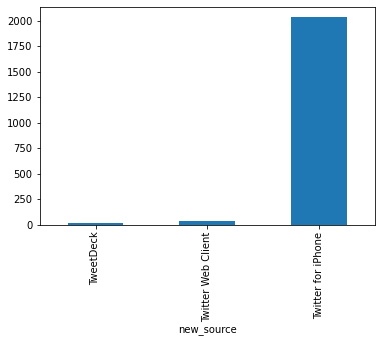

In [277]:
df_clean.groupby("new_source").tweet_id.count().plot(kind="bar")

from above plot, we can see "Twitter for iphone" got most cases, which is the most popular way for dog lovers.

I want to know the relationship of retweet_count and favorite_count, will more retweet_count bring more favorite_count?

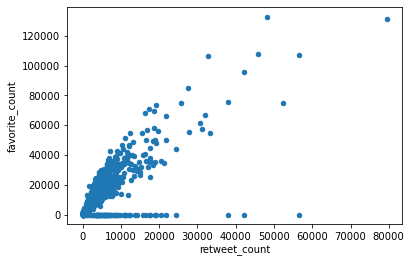

In [278]:
df_clean.plot(x="retweet_count",y="favorite_count",kind="scatter")

In [279]:
import statsmodels.api as sms;
df_clean["intercept"] =1
lm = sms.OLS(df_clean["favorite_count"],df_clean[["intercept","retweet_count"]])
result=lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     3449.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:04:40   Log-Likelihood:                -21413.
No. Observations:                2073   AIC:                         4.283e+04
Df Residuals:                    2071   BIC:                         4.284e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2926.0633    188.927     15.488      0.000    2555.557    3296.570
retweet_count     1.8920      0.032     58.732      0.000       1.829       1.955
==============================================================================
Omnibus:                     1515.027   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           150199.520
Skew:                          -2.670   Prob(JB):                         0.00
Kurtosis:                      44.357   Cond. No.                     6.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From above analysis, we can see the more retweet_count, the more favorite_count.

In [280]:
df_clean.groupby("p1_dog").mean()["p1_conf"]

p1_dog
False    0.540399
True     0.613696
Name: p1_conf, dtype: float64

In [281]:
df_clean.groupby("p2_dog").mean()["p2_conf"]

p2_dog
False    0.117213
True     0.140526
Name: p2_conf, dtype: float64

In [282]:
df_clean.groupby("p3_dog").mean()["p3_conf"]

p3_dog
False    0.056907
True     0.061658
Name: p3_conf, dtype: float64

we can see from above analysis,the higher prediction confidence, the more result is true.

In [283]:
df_clean.to_csv("twitter_archive_master.csv")